In [1]:
'''
Model:
    3 Layers GAT + 2 Layer FC
    hidden channel = 32
    training 1500 epoch
    Device Node Features = 5
    Train in Log HPWL
    Train for HPWL < Threshold (10000)
    

'''

'\nModel:\n    3 Layers GAT + 2 Layer FC\n    hidden channel = 32\n    training 1500 epoch\n    symmetric net\n    seperate capacitors and resistors\n    Device Node Features = 5\n    Train in Log HPWL\n    \n\n'

In [2]:
import numpy as np
import torch
torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import HeteroConv, BatchNorm, Linear, GATConv

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
print(torch.__version__)
!python --version
!nvcc --version
!cat /usr/include/cudnn.h | grep CUDNN_MAJOR -A 2

cuda
1.11.0+cu102
Python 3.8.6
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2018 NVIDIA Corporation
Built on Sat_Aug_25_21:08:01_CDT_2018
Cuda compilation tools, release 10.0, V10.0.130
#define CUDNN_MAJOR 7
#define CUDNN_MINOR 6
#define CUDNN_PATCHLEVEL 1
--
#define CUDNN_VERSION (CUDNN_MAJOR * 1000 + CUDNN_MINOR * 100 + CUDNN_PATCHLEVEL)

#include "driver_types.h"


cuda:1
1.11.0+cu102
Python 3.8.6
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2018 NVIDIA Corporation
Built on Sat_Aug_25_21:08:01_CDT_2018
Cuda compilation tools, release 10.0, V10.0.130
Device Node Features' Shape: (4500, 5)
Device Node Features' Mean: [8.2884856e+07 9.5396346e+08 7.7310615e+03 5.4090312e+03 9.1711110e-01]
Device Node Features' Std: [2.9770163e+08 1.8716833e+09 7.4117515e+03 9.5033213e+03 1.2663405e+00]
Net Node Features' Shape: (4325, 6)
Net Node Features' Mean: [6.4924854e-01 1.0543352e-01 4.0369943e-01 3.4751446e+00 3.9471447e+01
 3.0973297e+04]
Net Node Features' Std: [9.3648350e-01 3.0710986e-01 4.9063596e-01 3.5836630e+00 3.1141081e+01
 4.0331391e+04]
DataSet size:
258
Total Device: 4500
NumMos: 2771
NumCap: 370
NumRes: 320
NumBlock: 1039
Num wire: 3869
L min:5.123964
L max:13.18503
Interval: 0.06893414974212647


/tmp/ipykernel_18010/2236915981.py:2: RuntimeWarning: divide by zero encountered in log
  wirelength = np.log(net_features_list[:,-1])


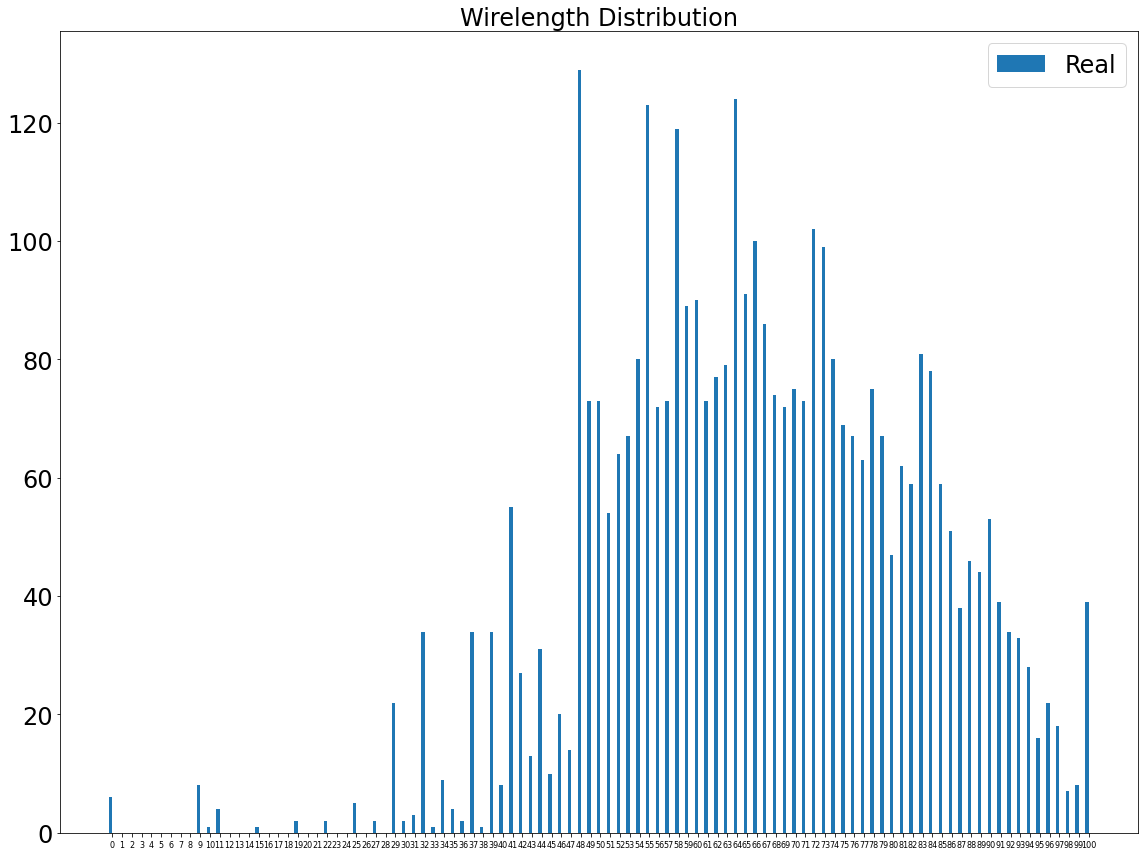

Num device: 4500
L min:1209600.0
L max:3048860000.0
Interval: 20889803.52


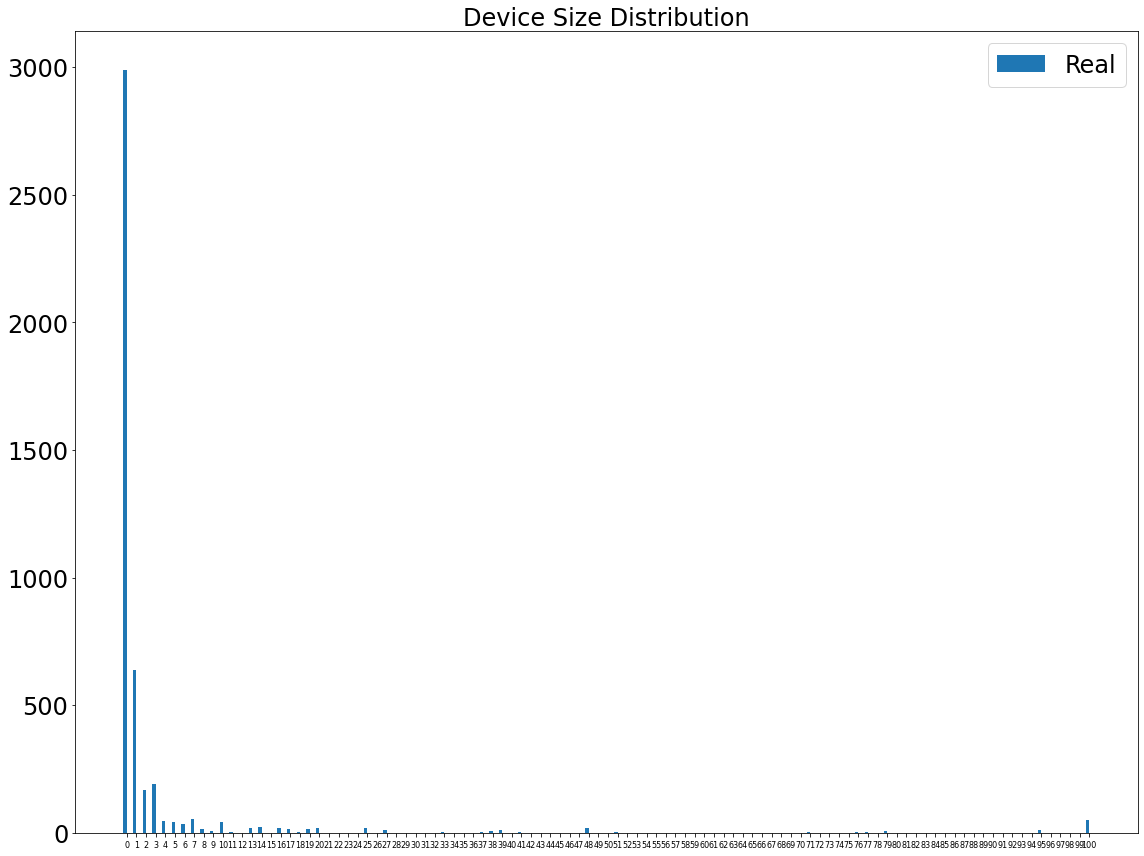

ALIGN(258)


In [4]:
%run ./Dataset_Generation_for_Log_HPWL.ipynb
#import import_ipynb
#import Dataset_Generation.ipynb
dataset = ALIGN(root='data_Log_Case')

In [5]:
from torch_geometric.loader import DataLoader
from torch_geometric.data import Dataset


train_dataset = dataset[0:233]
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

test_dataset = dataset[233:]
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

print(train_dataset)

ALIGN(233)


In [6]:
for i, data in enumerate(train_loader):
    print(i)
    print(data)
    print(data.edge_index_dict[('device', 'gate2net', 'net')])
    print(data.edge_index_dict[('net', 'net2gate', 'device')])
    break

0
HeteroDataBatch(
  device={
    x=[48, 5],
    batch=[48],
    ptr=[5]
  },
  net={
    y=[44],
    train_mask=[44],
    smallnet_mask=[44],
    largenet_mask=[44],
    x=[44, 5],
    batch=[44],
    ptr=[5]
  },
  (device, gate2net, net)={ edge_index=[2, 30] },
  (net, net2gate, device)={ edge_index=[2, 30] },
  (device, source2net, net)={ edge_index=[2, 77] },
  (net, net2source, device)={ edge_index=[2, 77] },
  (device, cap2net, net)={ edge_index=[2, 12] },
  (net, net2cap, device)={ edge_index=[2, 12] },
  (device, res2net, net)={ edge_index=[2, 18] },
  (net, net2res, device)={ edge_index=[2, 18] },
  (net, net2net, net)={ edge_index=[2, 24] }
)
tensor([[ 0,  2,  1,  3,  7, 10, 11, 13, 12, 14, 44, 45, 33, 28, 32, 39, 24, 26,
         40, 46, 41, 25, 16, 27, 21, 22, 34, 19, 19, 45],
        [ 1,  1,  2,  2, 10, 11, 14, 14, 15, 15, 18, 19, 21, 21, 21, 21, 21, 22,
         23, 25, 25, 26, 29, 32, 35, 36, 37, 38, 41, 42]])
tensor([[ 1,  1,  2,  2, 10, 11, 14, 14, 15, 15, 18, 19, 21

In [7]:
class Hetero_Model (torch.nn.Module):
    
    def __init__(self, heads=2, hidden_channel=32):
        super().__init__()
        
        self.fc1_device = Linear(in_channels=5, out_channels=hidden_channel)
        self.fc1_net    = Linear(in_channels=5, out_channels=hidden_channel)
        
        self.hetero_conv1 = HeteroConv({
                    ('device', 'gate2net', 'net'): GATConv(in_channels=hidden_channel, out_channels=hidden_channel, heads=2, dropout=0.5),
                    ('device', 'source2net', 'net'): GATConv(in_channels=hidden_channel, out_channels=hidden_channel, heads=2, dropout=0.5),
                    ('device', 'cap2net', 'net'): GATConv(in_channels=hidden_channel, out_channels=hidden_channel, heads=2, dropout=0.5),
                    ('device', 'res2net', 'net'): GATConv(in_channels=hidden_channel, out_channels=hidden_channel, heads=2, dropout=0.5),
                    ('net', 'net2gate', 'device'): GATConv(in_channels=hidden_channel, out_channels=hidden_channel, heads=2, dropout=0.5),
                    ('net', 'net2source', 'device'): GATConv(in_channels=hidden_channel, out_channels=hidden_channel, heads=2, dropout=0.5),
                    ('net', 'net2cap', 'device'): GATConv(in_channels=hidden_channel, out_channels=hidden_channel, heads=2, dropout=0.5),
                    ('net', 'net2res', 'device'): GATConv(in_channels=hidden_channel, out_channels=hidden_channel, heads=2, dropout=0.5),
                    ('net', 'net2net', 'net'): GATConv(in_channels=hidden_channel, out_channels=hidden_channel, heads=2, dropout=0.5)
                    }, aggr='sum')
        self.bnm1_device         = BatchNorm(hidden_channel*2)
        self.bnm1_net            = BatchNorm(hidden_channel*2)
        
        self.hetero_conv2 = HeteroConv({
                    ('device', 'gate2net', 'net'): GATConv(in_channels=hidden_channel*2, out_channels=hidden_channel, heads=2, dropout=0.5),
                    ('device', 'source2net', 'net'): GATConv(in_channels=hidden_channel*2, out_channels=hidden_channel, heads=2, dropout=0.5),
                    ('device', 'cap2net', 'net'): GATConv(in_channels=hidden_channel*2, out_channels=hidden_channel, heads=2, dropout=0.5),
                    ('device', 'res2net', 'net'): GATConv(in_channels=hidden_channel*2, out_channels=hidden_channel, heads=2, dropout=0.5),
                    ('net', 'net2gate', 'device'): GATConv(in_channels=hidden_channel*2, out_channels=hidden_channel, heads=2, dropout=0.5),
                    ('net', 'net2source', 'device'): GATConv(in_channels=hidden_channel*2, out_channels=hidden_channel, heads=2, dropout=0.5),
                    ('net', 'net2cap', 'device'): GATConv(in_channels=hidden_channel*2, out_channels=hidden_channel, heads=2, dropout=0.5),
                    ('net', 'net2res', 'device'): GATConv(in_channels=hidden_channel*2, out_channels=hidden_channel, heads=2, dropout=0.5),
                    ('net', 'net2net', 'net'): GATConv(in_channels=hidden_channel*2, out_channels=hidden_channel, heads=2, dropout=0.5)
                    }, aggr='sum')
        self.bnm2_device         = BatchNorm(hidden_channel*2)
        self.bnm2_net            = BatchNorm(hidden_channel*2)
            
        self.hetero_conv3 = HeteroConv({
                    ('device', 'gate2net', 'net'): GATConv(in_channels=hidden_channel*2, out_channels=hidden_channel, heads=2, dropout=0.5),
                    ('device', 'source2net', 'net'): GATConv(in_channels=hidden_channel*2, out_channels=hidden_channel, heads=2, dropout=0.5),
                    ('device', 'cap2net', 'net'): GATConv(in_channels=hidden_channel*2, out_channels=hidden_channel, heads=2, dropout=0.5),
                    ('device', 'res2net', 'net'): GATConv(in_channels=hidden_channel*2, out_channels=hidden_channel, heads=2, dropout=0.5),
                    ('net', 'net2gate', 'device'): GATConv(in_channels=hidden_channel*2, out_channels=hidden_channel, heads=2, dropout=0.5),
                    ('net', 'net2source', 'device'): GATConv(in_channels=hidden_channel*2, out_channels=hidden_channel, heads=2, dropout=0.5),
                    ('net', 'net2cap', 'device'): GATConv(in_channels=hidden_channel*2, out_channels=hidden_channel, heads=2, dropout=0.5),
                    ('net', 'net2res', 'device'): GATConv(in_channels=hidden_channel*2, out_channels=hidden_channel, heads=2, dropout=0.5),
                    ('net', 'net2net', 'net'): GATConv(in_channels=hidden_channel*2, out_channels=hidden_channel, heads=2, dropout=0.5)
                    }, aggr='sum')
        self.bnm3_device         = BatchNorm(hidden_channel*2)
        self.bnm3_net            = BatchNorm(hidden_channel*2)
        
        self.fc1  = Linear(hidden_channel*2*3, hidden_channel)
        self.bnm4 = BatchNorm(hidden_channel)
        self.fc2  = Linear(hidden_channel, 1)
        
    
    def forward(self, x_dict, edge_index_dict):
        
        x_dict['device'] = self.fc1_device(x_dict['device'])
        x_dict['net']    = self.fc1_net(x_dict['net'])
        

        x_dict           = self.hetero_conv1(x_dict, edge_index_dict)
        x_dict['device'] = self.bnm1_device(x_dict['device'])
        x_dict['net']    = self.bnm1_net(x_dict['net'])
        x_dict['device'] = F.elu(x_dict['device'])
        x_dict['net']    = F.elu(x_dict['net'])
        h1               = F.elu(x_dict['net'])
        
      
        x_dict           = self.hetero_conv2(x_dict, edge_index_dict)
        x_dict['device'] = self.bnm2_device(x_dict['device'])
        x_dict['net']    = self.bnm2_net(x_dict['net'])
        x_dict['device'] = F.elu(x_dict['device'])
        x_dict['net']    = F.elu(x_dict['net'])
        h2               = F.elu(x_dict['net'])
        
                
        x_dict           = self.hetero_conv3(x_dict, edge_index_dict)
        x_dict['device'] = self.bnm3_device(x_dict['device'])
        x_dict['net']    = self.bnm3_net(x_dict['net'])
        x_dict['device'] = F.elu(x_dict['device'])
        x_dict['net']    = F.elu(x_dict['net'])
        h3               = F.elu(x_dict['net'])
        
        x = torch.cat((h1, h2, h3), dim=1) 
        
        x = self.fc1(x)
        x = F.elu(x)
        x = F.dropout(x, 0.5, self.training)
        x = self.fc2(x)
        x = F.elu(x)
        
        return x

In [11]:
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')
print(device)
model = Hetero_Model().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.7)
criterion = nn.MSELoss()


cuda:1


In [30]:
#model.to(device)
#model.load_state_dict(torch.load('./HAT_Log_HPWL_small_case.pth')['model_state_dict'])
#optimizer.load_state_dict(torch.load('./HAT_Log_HPWL_small_case.pth')['optimizer_state_dict'])

#print(device)


cuda:1


In [31]:
model.train()
Model_Path = './HAT_Log_HPWL_small_case.pth'

i = 0
for epoch in range(1500):
    model.train()
        
    for data in train_loader:
        
        optimizer.zero_grad()  
        data.to(device)
        out = model(data.x_dict, data.edge_index_dict).squeeze()
        if (out[data.smallnet_mask_dict['net']].numel() == 0):
            continue
        loss = criterion(out[data.smallnet_mask_dict['net']], data.y_dict['net'][data.smallnet_mask_dict['net']])
        loss.backward()
        optimizer.step()
        
        #data.to('cpu')
        #torch.cuda.empty_cache()
    
    scheduler.step()
    if epoch%10 == 0:
        print(f'[{epoch + 1}] loss: {loss:.5f}')
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            }, Model_Path)
    if epoch%100 == 0:
        print(f'[{epoch + 1}] lr: {optimizer.param_groups[0]["lr"]}')
    
    

[1] loss: 0.18288
[1] lr: 0.0001412376244999999
[11] loss: 0.24909
[21] loss: 0.61085
[31] loss: 0.39379
[41] loss: 0.14890
[51] loss: 1.01287
[61] loss: 0.14071
[71] loss: 0.21445
[81] loss: 0.20535
[91] loss: 0.00457
[101] loss: 0.02949
[101] lr: 9.886633714999992e-05
[111] loss: 0.07988
[121] loss: 1.46591
[131] loss: 1.10803
[141] loss: 0.16802
[151] loss: 0.03939
[161] loss: 0.25030
[171] loss: 0.52822
[181] loss: 0.29863
[191] loss: 0.33909
[201] loss: 0.12668
[201] lr: 6.920643600499994e-05
[211] loss: 1.39873
[221] loss: 0.05022
[231] loss: 0.04228
[241] loss: 0.48188
[251] loss: 0.05094
[261] loss: 0.08579
[271] loss: 0.21886
[281] loss: 0.29478
[291] loss: 0.15046
[301] loss: 0.07957
[301] lr: 4.844450520349996e-05
[311] loss: 0.43574
[321] loss: 0.46513
[331] loss: 0.12497
[341] loss: 0.34957
[351] loss: 0.16259
[361] loss: 0.10428
[371] loss: 0.35403
[381] loss: 0.03385
[391] loss: 0.12321
[401] loss: 0.32294
[401] lr: 3.391115364244997e-05
[411] loss: 0.20560
[421] loss: 0

In [33]:
Model_Path = './HAT_Log_HPWL_small_case.pth'
torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            }, Model_Path)

In [ ]:
model.load_state_dict(torch.load('./HAT_Log_HPWL_small_case.pth')['model_state_dict'])
optimizer.load_state_dict(torch.load('./HAT_Log_HPWL_small_case.pth')['optimizer_state_dict'])

In [77]:
model.eval()
test_acc_list = []
out_list = []
ans_list = []
model.to('cpu')

for data in test_loader:
    
    out = model(data.x_dict, data.edge_index_dict).squeeze()
    loss = criterion(out[data.train_mask_dict['net']], data.y_dict['net'][data.train_mask_dict['net']])
    print(loss)
    
    out = torch.exp(out[data.train_mask_dict['net']]).detach().numpy()
    #print(out)
    
    ans = torch.exp(data.y_dict['net'][data.train_mask_dict['net']]).detach().numpy()
    #print(ans)
    
    mape = np.multiply(np.mean(np.divide(np.absolute(np.subtract(ans, out)), ans)), 100)
    mse = np.mean(np.absolute(np.subtract(ans, out)))
    print("MAPE: " + str(mape) + "%")
    print("MSE: " + str(mse))
    print()
    

    for i in range(out.shape[0]):
        if(ans[i] <= 10000):
            out_list.append(out[i])
            ans_list.append(ans[i])
    
        
#print(out_list)
#print(ans_list)

print(len(out_list))
print(len(ans_list))

out_list = np.array(out_list)
ans_list = np.array(ans_list) 
overall_mape = np.multiply(np.mean(np.divide(np.absolute(np.subtract(ans_list, out_list)), ans_list)), 100)
overall_mse = np.mean(np.absolute(np.subtract(ans_list, out_list)))
print("Overall MAPE: " + str(overall_mape) + "%")
print("Overall MSE: " + str(overall_mse))

tensor(0.2954, grad_fn=<MseLossBackward0>)
MAPE: 44.513776898384094%
MSE: 4047.1133

tensor(0.0925, grad_fn=<MseLossBackward0>)
MAPE: 22.188998758792877%
MSE: 1555.9365

tensor(2.7231, grad_fn=<MseLossBackward0>)
MAPE: 74.58164691925049%
MSE: 38443.117

tensor(1.6871, grad_fn=<MseLossBackward0>)
MAPE: 67.6525354385376%
MSE: 21037.725

tensor(4.7696, grad_fn=<MseLossBackward0>)
MAPE: 80.9588611125946%
MSE: 61766.47

tensor(0.4505, grad_fn=<MseLossBackward0>)
MAPE: 40.63539206981659%
MSE: 6368.322

tensor(3.0245, grad_fn=<MseLossBackward0>)
MAPE: 93.47134828567505%
MSE: 20326.756

tensor(0.6134, grad_fn=<MseLossBackward0>)
MAPE: 50.53852200508118%
MSE: 7729.1665

tensor(3.4374, grad_fn=<MseLossBackward0>)
MAPE: 80.69104552268982%
MSE: 43900.426

tensor(1.0261, grad_fn=<MseLossBackward0>)
MAPE: 41.572168469429016%
MSE: 13297.471

tensor(2.3759, grad_fn=<MseLossBackward0>)
MAPE: 72.01969027519226%
MSE: 27140.49

tensor(1.2740, grad_fn=<MseLossBackward0>)
MAPE: 59.75760221481323%
MSE: 14561

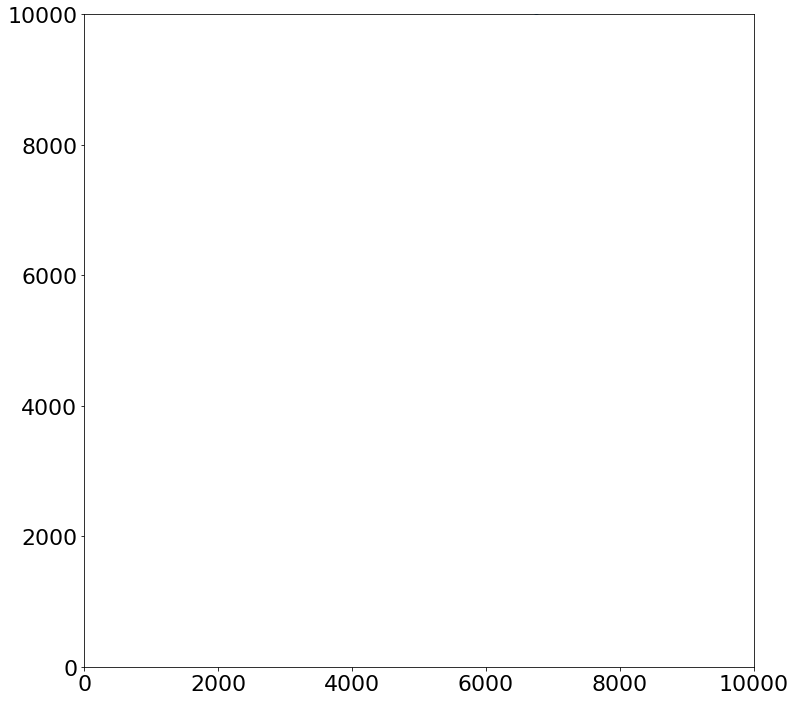

In [78]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize = (12, 12))
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)

ax.scatter(out_list, ans_list, alpha=0.7)
ax.set_xlim(0, 10000)
ax.set_ylim(0, 10000)

m, b = np.polyfit(out_list, ans_list, 1)
plt.plot(out_list, m*out_list + b, 'r')

plt.show()

In [49]:
N = 50

num_wire = len(out_list)
ans_sorted = np.sort(ans_list)
#out_sorted = np.sort(out_list) 
print("Num wire: " + str(num_wire))
    
L_min = ans_sorted[0]
L_max = ans_sorted[(num_wire-1) - int(0.01*num_wire)]
print("L min:" + str(L_min))
print("L max:" + str(L_max))
    
ans_label = np.zeros(num_wire)
out_label = np.zeros(num_wire)
interval = (L_max-L_min) / N
print("Interval: " + str(interval))
    
       
for i in range(N+1):
    interval_min = L_min + (i*interval)
    interval_max = L_min + ((i+1)*interval)
        
    if (i == N):
        ans_label = np.where((ans_list >= interval_min), i, ans_label)
        out_label = np.where((out_list >= interval_min), i, out_label)
    else:
        ans_label = np.where((ans_list >= interval_min) & (ans_list < interval_max), i, ans_label)
        out_label = np.where((out_list >= interval_min) & (out_list < interval_max), i, out_label)
            
#print(out_label)
#print(ans_label)
 
avg_value = np.zeros(N+1)
bin_num = np.zeros(N+1)
pred_avg_value = np.zeros(N+1)
pred_bin_num = np.zeros(N+1)
    
print("correlation: ")
    
for i in range(N+1):
    
    ans_mask = np.where(ans_label == i, True, False)
    bin_num[i] = len(ans_list[ans_mask])
    avg_value[i] = np.mean(ans_list[ans_mask])
        
    pred_mask = np.where(out_label == i, True, False)
    pred_bin_num[i] = len(out_list[pred_mask])
    pred_avg_value[i] = np.mean(out_list[pred_mask])

print(bin_num)
print(pred_bin_num)
    
#print(avg_value)
#print(pred_avg_value)
    
#print(np.corrcoef(avg_value, pred_avg_value))
      
    
print("MAPE:")
    
mape = np.multiply(np.divide(np.absolute(np.subtract(ans_list, out_list)), ans_list), 100)
   
mape_list = []
for i in range(N+1):
    out_mask = np.where(out_label == i, True, False)
    mape_list.append(np.mean(mape[out_mask]))
        
#print(mape)
print(mape.mean())
print(mape_list)
    
    
print("====================================")
#break

Num wire: 1181
L min:167.99997
L max:9904.001
Interval: 194.72001953125
correlation: 
[14.  5.  2.  1.  6. 21.  3. 32.  9.  4. 30.  2. 36. 32. 26. 22. 12. 16.
 10.  9. 12.  2. 14. 99. 37. 31. 26. 37. 18. 29. 28. 28. 12. 24. 25. 10.
 57. 18. 49. 58. 16. 29.  9. 29. 16. 34. 43. 20. 26. 40. 13.]
[ 3.  1.  2.  0.  3.  5.  2.  0.  0.  0.  4.  1.  3.  4.  1.  2.  4. 15.
 30. 38. 22. 50. 40. 56. 59. 68. 81. 83. 62. 58. 33. 39. 43. 48. 49. 25.
 37. 36. 51. 44. 32. 20. 16.  1.  5.  2.  2.  1.  0.  0.  0.]
MAPE:
49.556644
[39.838703, 164.67487, 142.84586, nan, 126.89571, 261.96716, 561.114, nan, nan, nan, 46.66565, 129.9048, 40.855473, 276.05353, 26.142374, 24.127768, 45.2244, 61.56803, 103.57402, 81.977135, 86.1863, 89.111404, 56.16936, 103.73629, 44.358253, 44.382515, 58.618027, 58.66122, 38.427406, 39.18404, 42.51575, 40.057777, 42.507046, 26.767746, 27.030575, 21.115192, 27.390463, 12.888219, 11.922804, 19.356306, 12.381049, 12.760159, 14.643978, 6.2868743, 12.737059, 8.142653, 11.490189, 21

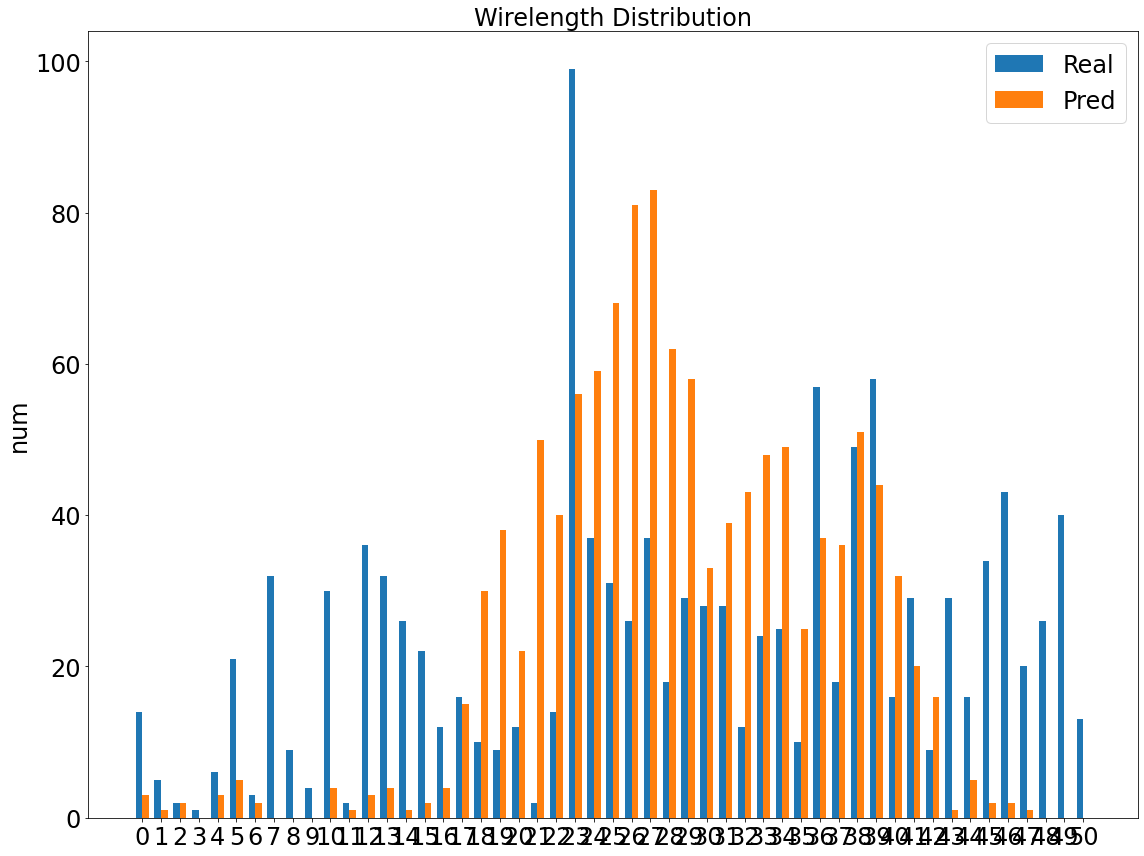

In [50]:
import matplotlib.pyplot as plt
labels = [i for i in range(N+1)]

x = np.arange(N+1)  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, bin_num, width, label='Real')
rects2 = ax.bar(x + width/2, pred_bin_num, width, label='Pred')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('num', fontsize=24)
ax.set_title('Wirelength Distribution', fontsize=24)
plt.yticks(fontsize=24)
ax.set_xticks(x, labels, fontsize=24)
ax.legend(loc='best', fontsize=24)


fig.set_size_inches(16, 12)
fig.tight_layout()

plt.show()


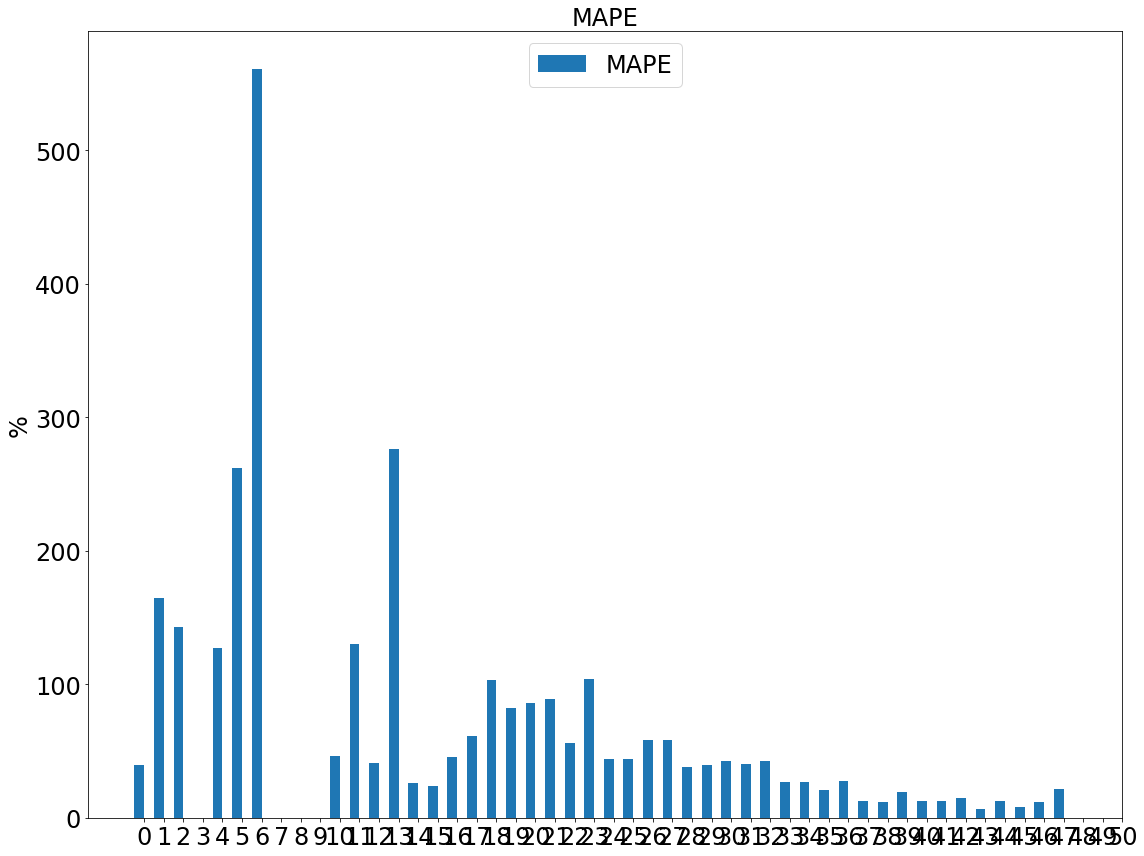

In [53]:
labels = [i for i in range(N+1)]



x = np.arange(N+1)  # the label locations
width = 0.5  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, mape_list, width, label='MAPE')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('%', fontsize=24)
ax.set_title('MAPE', fontsize=24)
plt.yticks(fontsize=24)
ax.set_xticks(x, labels, fontsize=24)
ax.legend(loc='best', fontsize=24)


fig.set_size_inches(16, 12)
fig.tight_layout()

plt.show()